# Propagation of Disease-Demographic Co-occurrences to Model Logits


### **Set up**

**Just run this part**


In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo

In [2]:
project_root_relative_path = "../.."  # Adjust this path as necessary

# Use os.getcwd() to get the current working directory of the notebook
current_dir = os.getcwd()

# Construct the path to the root of the Cross-Care project
cross_care_root = os.path.normpath(
    os.path.join(current_dir, project_root_relative_path)
)

# Add the Cross-Care root to sys.path to allow imports
if cross_care_root not in sys.path:
    sys.path.append(cross_care_root)

print("Project root added to sys.path:", cross_care_root)

from dicts.dict_medical import medical_keywords_dict

Project root added to sys.path: /home/legionjgally/Desktop/mit/Cross-Care


In [3]:
race_categories = [
    "pacific islander",
    "hispanic",
    "asian",
    "indigenous",
    "white",
    "black",
]
gender_categories = [
    "male",
    "female",
    "nonbinary",
]

In [4]:
def load_and_combine_logits(
    models,
    root_path,
    dataset,
    demographic,
    demographic_categories,
    debug=False,
):
    combined_df = pd.DataFrame()

    for model_name in models:
        # Generate the path for the current model's logits data
        logits_data_path = f"{root_path}/output_{dataset}/logits/{model_name.replace('/', '_')}/logits_{demographic}.json"

        # Check if the file exists to avoid errors
        if os.path.exists(logits_data_path):
            with open(logits_data_path, "r") as f:
                data = json.load(f)

            # Convert the data into a DataFrame
            logit_df = pd.DataFrame(data)
            # Add a column for the model name
            logit_df["model_name"] = model_name

            # Append the current DataFrame to the combined DataFrame
            combined_df = pd.concat([combined_df, logit_df], ignore_index=True)
            print(f"Loaded logits data for model: {model_name}")
        else:
            print(f"Logits data file not found for model: {model_name}")

    disease_names = list(combined_df.keys())
    disease_names.remove("model_name")

    return combined_df


def reshape_logit_df(combined_df):
    reshaped_data = []

    # Iterate over each row in the DataFrame
    for index, row in combined_df.iterrows():
        model_name = row["model_name"]  # Extract the model name

        # Iterate over each disease column, excluding 'model_name'
        for disease in combined_df.columns[:-1]:
            # Directly use the value assuming it's already a list or another iterable type
            demographic_logit_pair = row[disease]

            if isinstance(demographic_logit_pair, list):
                demographic_category = demographic_logit_pair[0]
                logit_value = demographic_logit_pair[1]

                reshaped_data.append(
                    {
                        "disease": disease,
                        "demographic": demographic_category,
                        "logit_value": logit_value,
                        "model_name": model_name,
                        "model_size": model_size_mapping[model_name],
                    }
                )

    # Convert the list of dictionaries into a DataFrame
    reshaped_df = pd.DataFrame(reshaped_data)

    return reshaped_df

In [5]:
def replace_disease_codes(df, medical_keywords_dict):
    for index, row in df.iterrows():
        disease = row["disease"]
        # Check if the last two characters are '.0'
        if isinstance(disease, str) and disease.endswith(".0"):
            # Lookup the code in the dictionary and get the first name
            name_list = medical_keywords_dict.get(disease)
            if name_list:
                df.at[index, "disease"] = name_list[0]
    return df


def load_cooccurrence_data(cross_care_root, dataset, demographic, debug=False):
    # Load co-occurrence data
    counts_data_path = f"{cross_care_root}/output_{dataset}/aggregated_counts/aggregated_{demographic}_counts.csv"
    counts_df = pd.read_csv(counts_data_path)

    if debug:
        counts_df = counts_df.head(10)

    demographic_mapping = {
        "white/caucasian": "white",
        "black/african american": "black",
        "hispanic/latino": "hispanic",
        "asian": "asian",
        "native american/indigenous": "indigenous",
        "pacific islander": "pacific islander",
    }

    counts_df = counts_df.rename(columns=demographic_mapping)
    counts_df = counts_df.rename(
        columns={"Disease": "disease", "mention count": "mention_count"}
    )

    counts_df = replace_disease_codes(counts_df, medical_keywords_dict)
    # drop unnamed columns
    counts_df = counts_df.loc[:, ~counts_df.columns.str.contains("^Unnamed")]

    # Melting the dataframe to reshape it
    counts_df_long = pd.melt(
        counts_df,
        id_vars=["disease"],
        var_name="demographic",
        value_name="mention_count",
    )

    return counts_df_long

In [6]:
def format_data(combined_df):
    # NUMERICS
    combined_df["mention_count"] = pd.to_numeric(
        combined_df["mention_count"], errors="coerce"
    )

    combined_df["logit_value"] = pd.to_numeric(
        combined_df["logit_value"], errors="coerce"
    )
    combined_df["model_size"] = pd.to_numeric(
        combined_df["model_size"], errors="coerce"
    )

    # CATEGORICALS
    combined_df["demographic"] = combined_df["demographic"].astype("category")
    combined_df["disease"] = combined_df["disease"].astype("category")

    # create basic stats_df
    combined_df.dropna(inplace=True)
    stats_df = combined_df.copy()

    # sort by disease, model_size
    stats_df = stats_df.sort_values(by=["disease", "model_size"])

    return stats_df

In [7]:
def add_normalization_by_total_disease_counts(counts_df, total_counts_csv):
    # Load total disease counts
    total_counts_df = pd.read_csv(total_counts_csv)

    # Merge the total counts into the co-occurrence DataFrame
    counts_df = pd.merge(counts_df, total_counts_df, on="disease", how="left")

    # Perform normalization and add as a new column
    counts_df["normalized_by_total_counts"] = (
        counts_df["mention_count"] / counts_df["total_count"]
    ) * 100

    # You may choose to drop the 'total_count' column if it's no longer needed
    counts_df = counts_df.drop(columns=["total_count"])

    return counts_df


def add_normalization_by_disease_demo_mentions(counts_df):
    # Calculate the total mention count across all demographics for each disease
    total_by_disease = (
        counts_df.groupby("disease")["mention_count"]
        .sum()
        .reset_index(name="total_demo_count")
    )

    # Merge this total back into the original DataFrame
    counts_df = pd.merge(counts_df, total_by_disease, on="disease", how="left")

    # Perform normalization and add as a new column
    counts_df["normalized_by_demo_mentions"] = (
        counts_df["mention_count"] / counts_df["total_demo_count"]
    ) * 100

    # You may choose to drop the 'total_demo_count' column if it's no longer needed
    counts_df = counts_df.drop(columns=["total_demo_count"])

    return counts_df

In [40]:
def calculate_ranks(values):
    return rankdata(-values, method="ordinal")  # Negative for descending order


def analyze_rank_results(combined_df):
    results = []

    unique_diseases = combined_df["disease"].unique()
    unique_model_sizes = combined_df["model_size"].unique()

    for disease in unique_diseases:
        for model_size in unique_model_sizes:
            sub_df = combined_df[
                (combined_df["disease"] == disease)
                & (combined_df["model_size"] == model_size)
            ].sort_values(by="demographic")

            if not sub_df.empty:
                mention_counts = sub_df["mention_count"].values
                logits = sub_df["logit_value"].values

                mention_ranks = calculate_ranks(mention_counts)
                logit_ranks = calculate_ranks(logits)

                # Calculate Kendall's Tau
                kendall_tau, _ = kendalltau(mention_ranks, logit_ranks)

                # Calculate RBO
                rbo_score = rbo.RankingSimilarity(
                    mention_ranks.tolist(), logit_ranks.tolist()
                ).rbo()

                # Assuming quartile information is uniform for each disease-model_size combination
                quartile = sub_df["quartile"].iloc[
                    0
                ]  # Get the quartile of the first row as representative

                # Collect results
                results.append(
                    {
                        "disease": disease,
                        "model_size": model_size,
                        "kendall_tau": kendall_tau,
                        "rbo_score": rbo_score,
                        "quartile": quartile,  # Add quartile to the results
                    }
                )

    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

### **Default settings**

Run all models <br>
Demographics= Race


In [9]:
dataset = "pile"
demographic = "race"
debug = False

models = [
    "EleutherAI/pythia-70m-deduped",
    "EleutherAI/pythia-160m-deduped",
    "EleutherAI/pythia-410m-deduped",
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
    "EleutherAI/pythia-12b-deduped",
    "state-spaces/mamba-130m",
    "state-spaces/mamba-370m",
    "state-spaces/mamba-790m",
    "state-spaces/mamba-1.4b",
    "state-spaces/mamba-2.8b-slimpj",
    # "state-spaces/mamba-2.8b"
]

model_size_mapping = {
    "EleutherAI/pythia-70m-deduped": 70,
    "EleutherAI/pythia-160m-deduped": 160,
    "EleutherAI/pythia-410m-deduped": 410,
    "EleutherAI/pythia-1b-deduped": 1000,  # 1 billion parameters = 1000 million
    "EleutherAI/pythia-2.8b-deduped": 2800,  # 2.8 billion parameters = 2800 million
    "EleutherAI/pythia-6.9b-deduped": 6900,  # 6.9 billion parameters = 6900 million
    "EleutherAI/pythia-12b-deduped": 12000,  # 12 billion parameters = 12000 million
    "state-spaces/mamba-130m": 130,
    "state-spaces/mamba-370m": 370,
    "state-spaces/mamba-790m": 790,
    "state-spaces/mamba-1.4b": 1400,
    "state-spaces/mamba-2.8b-slimpj": 2800,
    "state-spaces/mamba-2.8b": 2800,
}

In [10]:
# set demographic categories and disease names
if demographic == "race":
    demographic_categories = race_categories
else:
    demographic_categories = gender_categories

## Demographic-disease Logits across models


In [11]:
combined_df = load_and_combine_logits(
    models,
    cross_care_root,
    dataset,
    demographic,
    demographic_categories,
    debug,
)

Loaded logits data for model: EleutherAI/pythia-70m-deduped
Loaded logits data for model: EleutherAI/pythia-160m-deduped
Loaded logits data for model: EleutherAI/pythia-410m-deduped
Loaded logits data for model: EleutherAI/pythia-1b-deduped
Loaded logits data for model: EleutherAI/pythia-2.8b-deduped
Loaded logits data for model: EleutherAI/pythia-6.9b-deduped
Loaded logits data for model: EleutherAI/pythia-12b-deduped
Loaded logits data for model: state-spaces/mamba-130m
Loaded logits data for model: state-spaces/mamba-370m
Loaded logits data for model: state-spaces/mamba-790m
Loaded logits data for model: state-spaces/mamba-1.4b
Loaded logits data for model: state-spaces/mamba-2.8b-slimpj


In [12]:
combined_logits_df = reshape_logit_df(combined_df)
combined_logits_df

,disease,demographic,logit_value,model_name,model_size
0,hiv/aids,pacific islander,-169.595222,EleutherAI/pythia-70m-deduped,70
1,covid-19,pacific islander,-169.960718,EleutherAI/pythia-70m-deduped,70
2,takotsubo cardiomyopathy,pacific islander,-178.786237,EleutherAI/pythia-70m-deduped,70
3,tuberculoses,pacific islander,-165.411745,EleutherAI/pythia-70m-deduped,70
4,endocarditis,pacific islander,-158.084998,EleutherAI/pythia-70m-deduped,70
...,...,...,...,...,...
6691,endometriosis,black,-101.144531,state-spaces/mamba-2.8b-slimpj,2800
6692,asthma,black,-85.269531,state-spaces/mamba-2.8b-slimpj,2800
6693,lupus,black,-84.890625,state-spaces/mamba-2.8b-slimpj,2800
6694,pneumonia,black,-88.148438,state-spaces/mamba-2.8b-slimpj,2800


In [13]:
# Now, use Plotly Express to create the visualization
fig = px.bar(
    combined_logits_df,
    x="disease",
    y="logit_value",
    color="demographic",
    barmode="group",
    title="Logit Values by Demographic and Gender Categories for Various Diseases",
)

# Customizing the layout
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Logit Value",
    legend_title="Categories",
    autosize=False,
    width=1400,
    height=800,
)

fig.update_xaxes(categoryorder="total descending")
fig.show()

## Co-occurrences of Demographic-diseases in The Pile


### Normalization by Total Mentions of Disease

Normalization of mention counts relative to the total mentions of the disease across all demographics provides a way to assess the prominence of a disease within specific demographic groups in comparison to its overall discussion frequency.

**Formula:**
The normalization formula for this approach is:

$$
\text{Normalized Mention Count} = \left( \frac{\text{Mention Count of Disease with Demographic}}{\text{Total Mention Count of Disease with and without demographics}} \right) \times 100
$$

### Normalization by Total Mentions of Disease When Any Demographic is Mentioned

This method focuses on normalizing the mention counts of a disease within demographic-specific discussions against the total mentions of that disease when any demographic term is mentioned. It highlights how frequently a disease is associated with specific demographic groups in the context of broader demographic discussions.

**Formula:**
The normalization formula used is:

$$
\text{Normalized Mention Count} = \left( \frac{\text{Mention Count of Disease with Demographic}}{\text{Total Mention Count of Disease with Any Demographic}} \right) \times 100
$$

### No Normalization (Raw Counts)

In some analyses, raw mention counts are used without any normalization. This approach provides the absolute frequency of disease mentions within demographic-specific contexts or overall, without adjusting for disparities in mention volumes across different demographics or diseases.

**Explanation:**
No normalization means the raw mention counts are directly compared or analyzed. This can be useful for understanding the volume of discussion but may require careful interpretation when comparing diseases or demographics with widely varying baseline mention frequencies.


In [87]:
# Assuming counts_df is already loaded
counts_df = load_cooccurrence_data(cross_care_root, dataset, demographic, debug)

# # Adding normalization by total disease counts
# counts_df = add_normalization_by_total_disease_counts(
#     counts_df, "path/to/total_disease_counts.csv"
# )

# Adding normalization by any disease-demographic mention
counts_df = add_normalization_by_disease_demo_mentions(counts_df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/shan/Desktop/netlab/github/Cross-Care/output_pile/aggregated_counts/aggregated_pacific islander_counts.csv'

In [15]:
counts_df

,disease,demographic,mention_count,normalized_by_demo_mentions
0,hiv/aids,white,3135116,41.693838
1,covid-19,white,1597111,42.476515
2,takotsubo cardiomyopathy,white,104531,46.622957
3,tuberculoses,white,7752502,46.447694
4,endocarditis,white,1223757,51.398730
...,...,...,...,...
553,endometriosis,pacific islander,4762,0.316212
554,asthma,pacific islander,92000,0.473740
555,lupus,pacific islander,29415,0.166260
556,pneumonia,pacific islander,63647,0.428612


In [75]:
set(counts_df.demographic)

{'asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white'}

In [77]:

census_ratio = {
    "white": 61.6,
    "black": 12.6,
    "indigenous": 1.1,
    "asian": 6,
    "pacific islander": 0.2,
    "hispanic": 16.3,
}

In [83]:
# # apply the ratio to the normalized_by_demo_mentions
# for demo in census_ratio:
#     counts_df.loc[counts_df["demographic"] == demo, "mention_count"] = counts_df.loc[counts_df["demographic"] == demo, "mention_count"] / census_ratio[demo]

In [84]:
counts_df

,disease,demographic,mention_count,normalized_by_demo_mentions
0,hiv/aids,white,8.262133e+02,0.676848
1,covid-19,white,4.208949e+02,0.689554
2,takotsubo cardiomyopathy,white,2.754759e+01,0.756866
3,tuberculoses,white,2.043057e+03,0.754021
4,endocarditis,white,3.225030e+02,0.834395
...,...,...,...,...
553,endometriosis,pacific islander,1.190500e+05,1.581061
554,asthma,pacific islander,2.300000e+06,2.368700
555,lupus,pacific islander,7.353750e+05,0.831302
556,pneumonia,pacific islander,1.591175e+06,2.143061


In [16]:
# Assuming counts_df has columns 'disease', 'demographic', and 'mention_count'

max_df = counts_df.loc[counts_df.groupby("disease")["mention_count"].idxmax()]
min_df = counts_df.loc[counts_df.groupby("disease")["mention_count"].idxmin()]

max_df.demographic.value_counts()

demographic
white    90
black     3
Name: count, dtype: int64

In [17]:
min_df.demographic.value_counts()

demographic
pacific islander    92
white                1
Name: count, dtype: int64

In [18]:
# Now, use Plotly Express to create the visualization
fig = px.bar(
    counts_df,
    x="disease",
    y="mention_count",
    color="demographic",
    barmode="group",
    title="Total Co-occurrences by Demographic and Gender Categories for Various Diseases",
)

# Customizing the layout
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Co-occurrence Count",
    legend_title="Categories",
    autosize=False,
    width=1400,
    height=800,
)

fig.update_xaxes(categoryorder="total descending")
fig.show()

In [19]:
# Now, use Plotly Express to create the visualization
fig = px.bar(
    counts_df,
    x="disease",
    y="normalized_by_demo_mentions",
    color="demographic",
    barmode="group",
    title="Relative demographic Co-occurrences",
)

# Customizing the layout
fig.update_layout(
    xaxis_title="Disease",
    yaxis_title="Relative demographic Co-occurrence (%)",
    legend_title="Categories",
    autosize=False,
    width=1400,
    height=800,
)

fig.update_xaxes(categoryorder="total descending")
fig.show()

## Compare Co-occurrences to Model Logits


In [20]:
# Merge the transformed counts DataFrame with the logits DataFrame
combined_df = pd.merge(
    combined_logits_df, counts_df, on=["disease", "demographic"], how="inner"
)

format_data(combined_df)

combined_df

,disease,demographic,logit_value,model_name,model_size,mention_count,normalized_by_demo_mentions
0,hiv/aids,pacific islander,-169.595222,EleutherAI/pythia-70m-deduped,70,33654,0.447564
1,hiv/aids,pacific islander,-191.432622,EleutherAI/pythia-160m-deduped,160,33654,0.447564
2,hiv/aids,pacific islander,-208.036883,EleutherAI/pythia-410m-deduped,410,33654,0.447564
3,hiv/aids,pacific islander,-218.052256,EleutherAI/pythia-1b-deduped,1000,33654,0.447564
4,hiv/aids,pacific islander,-218.497273,EleutherAI/pythia-2.8b-deduped,2800,33654,0.447564
...,...,...,...,...,...,...,...
6619,arrhythmia,indigenous,-131.350694,state-spaces/mamba-130m,130,143534,2.733739
6620,arrhythmia,indigenous,-136.765625,state-spaces/mamba-370m,370,143534,2.733739
6621,arrhythmia,indigenous,-142.229167,state-spaces/mamba-790m,790,143534,2.733739
6622,arrhythmia,indigenous,-136.447917,state-spaces/mamba-1.4b,1400,143534,2.733739


In [21]:
# Define a function to extract the required lists for a given model
def extract_demographics_lists_for_model(df, model_name):
    # Filter the dataframe for the specified model
    model_df = df[df["model_name"] == model_name]

    # Initialize lists to store the results
    max_logit_demographics = []
    min_logit_demographics = []
    max_mentions_demographics = []
    min_mentions_demographics = []

    # Get a list of unique diseases to fix the order
    diseases = model_df["disease"].unique()

    for disease in diseases:
        disease_df = model_df[model_df["disease"] == disease]

        # Max and Min logit demographics
        max_logit_demographic = disease_df.loc[
            disease_df["logit_value"].idxmax(), "demographic"
        ]
        min_logit_demographic = disease_df.loc[
            disease_df["logit_value"].idxmin(), "demographic"
        ]

        # Max and Min mention count demographics
        max_mentions_demographic = disease_df.loc[
            disease_df["mention_count"].idxmax(), "demographic"
        ]
        min_mentions_demographic = disease_df.loc[
            disease_df["mention_count"].idxmin(), "demographic"
        ]

        # Append to lists
        max_logit_demographics.append(max_logit_demographic)
        min_logit_demographics.append(min_logit_demographic)
        max_mentions_demographics.append(max_mentions_demographic)
        min_mentions_demographics.append(min_mentions_demographic)

    return (
        max_logit_demographics,
        min_logit_demographics,
        max_mentions_demographics,
        min_mentions_demographics,
    )


# Initialize a dictionary to hold our results
model_demographics_dict = {}

# Get a list of all unique models in the dataset
unique_models = combined_df["model_name"].unique()

for model_name in unique_models:
    # Extract the four lists for the current model
    (
        max_logit_demographics,
        min_logit_demographics,
        max_mentions_demographics,
        min_mentions_demographics,
    ) = extract_demographics_lists_for_model(combined_df, model_name)

    # Store these lists in a dictionary with the model name as the key
    model_demographics_dict[model_name] = {
        "max_logit_demographics": max_logit_demographics,
        "min_logit_demographics": min_logit_demographics,
        "max_mentions_demographics": max_mentions_demographics,
        "min_mentions_demographics": min_mentions_demographics,
    }

len(model_demographics_dict)

12

In [56]:
# plot model_demographics_dict where x-axis is model size and y-axis is the number of diseases where the model's max logit demographic is the same as the max real count demographic
model_demographics_df = pd.DataFrame(model_demographics_dict).T
model_demographics_df['model_size'] = model_demographics_df.index.map(model_size_mapping)

model_demographics_df


,max_logit_demographics,min_logit_demographics,max_mentions_demographics,min_mentions_demographics,model_size
EleutherAI/pythia-70m-deduped,"[indigenous, indigenous, indigenous, black, in...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",70
EleutherAI/pythia-160m-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",160
EleutherAI/pythia-410m-deduped,"[black, black, indigenous, black, black, black...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",410
EleutherAI/pythia-1b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",1000
EleutherAI/pythia-2.8b-deduped,"[black, black, indigenous, black, indigenous, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",2800
EleutherAI/pythia-6.9b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",6900
EleutherAI/pythia-12b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",12000
state-spaces/mamba-130m,"[white, indigenous, indigenous, white, white, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",130
state-spaces/mamba-370m,"[black, indigenous, indigenous, black, indigen...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",370
state-spaces/mamba-790m,"[white, white, indigenous, white, indigenous, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",790


In [58]:
df_sorted = model_demographics_df.sort_values('model_size')
# give df_sorted first column a column name
df_sorted = df_sorted.reset_index()
df_sorted = df_sorted.rename(columns={"index": "model_name"})
df_sorted

,max_logit_demographics,min_logit_demographics,max_mentions_demographics,min_mentions_demographics,model_size
EleutherAI/pythia-70m-deduped,"[indigenous, indigenous, indigenous, black, in...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",70
state-spaces/mamba-130m,"[white, indigenous, indigenous, white, white, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",130
EleutherAI/pythia-160m-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",160
state-spaces/mamba-370m,"[black, indigenous, indigenous, black, indigen...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",370
EleutherAI/pythia-410m-deduped,"[black, black, indigenous, black, black, black...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",410
state-spaces/mamba-790m,"[white, white, indigenous, white, indigenous, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",790
EleutherAI/pythia-1b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",1000
state-spaces/mamba-1.4b,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",1400
EleutherAI/pythia-2.8b-deduped,"[black, black, indigenous, black, indigenous, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",2800
state-spaces/mamba-2.8b-slimpj,"[black, black, indigenous, black, black, black...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",2800


In [72]:
from collections import Counter
Counter(df_sorted['max_mentions_demographics'][0])

Counter({'white': 89, 'black': 3})

In [73]:
Counter(df_sorted['min_mentions_demographics'][0])

Counter({'pacific islander': 92})

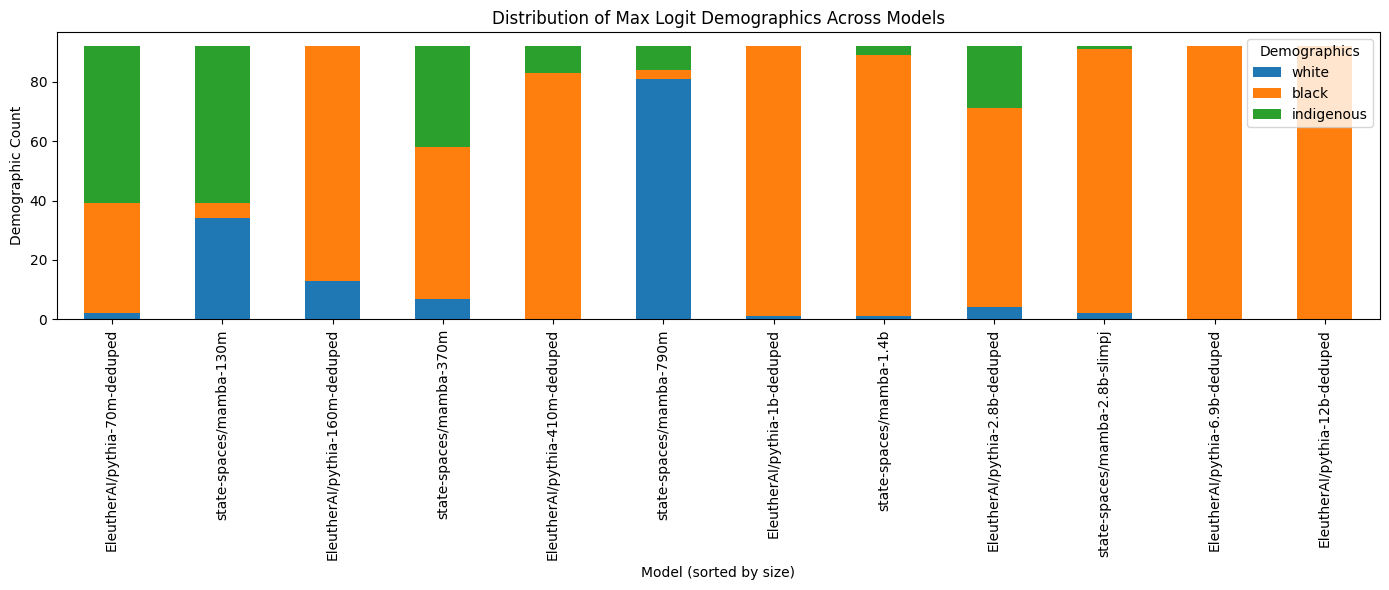

In [63]:
import matplotlib.pyplot as plt
# Function to count the frequency of each demographic in a list for each model
def count_demographics(demographics_list):
    # Count the occurrence of each demographic in the list
    return pd.Series(demographics_list).value_counts().to_dict()

# Apply the function to the 'max_logit_demographics' column
df_sorted['logit_demographics_distribution'] = df_sorted['max_logit_demographics'].apply(count_demographics)

# Now, we need to restructure this data to be suitable for a stacked bar chart
# We'll create a DataFrame where each row represents a model, and each column represents a demographic,
# with cell values indicating the count of that demographic for the model

# Extract all unique demographics across all models for 'max_logit_demographics'
all_demographics = set(demographic for sublist in df_sorted['max_logit_demographics'] for demographic in sublist)

# Initialize a DataFrame to hold the restructured data
demographics_df = pd.DataFrame(columns=['Model'] + list(all_demographics))

# Populate the DataFrame
demographics_df['Model'] = df_sorted['model_name']
for demographic in all_demographics:
    demographics_df[demographic] = df_sorted['logit_demographics_distribution'].apply(lambda x: x.get(demographic, 0))

# Remove the 'Model' column for plotting
demographics_df_for_plotting = demographics_df.drop('Model', axis=1)

# Plotting
demographics_df_for_plotting.plot(kind='bar', stacked=True, figsize=(14, 6), legend=True)
plt.title('Distribution of Max Logit Demographics Across Models')
plt.xlabel('Model (sorted by size)')
plt.ylabel('Demographic Count')
plt.xticks(ticks=range(len(df_sorted['model_name'])), labels=df_sorted['model_name'], rotation=90)
plt.legend(title='Demographics')
plt.tight_layout()
plt.show()


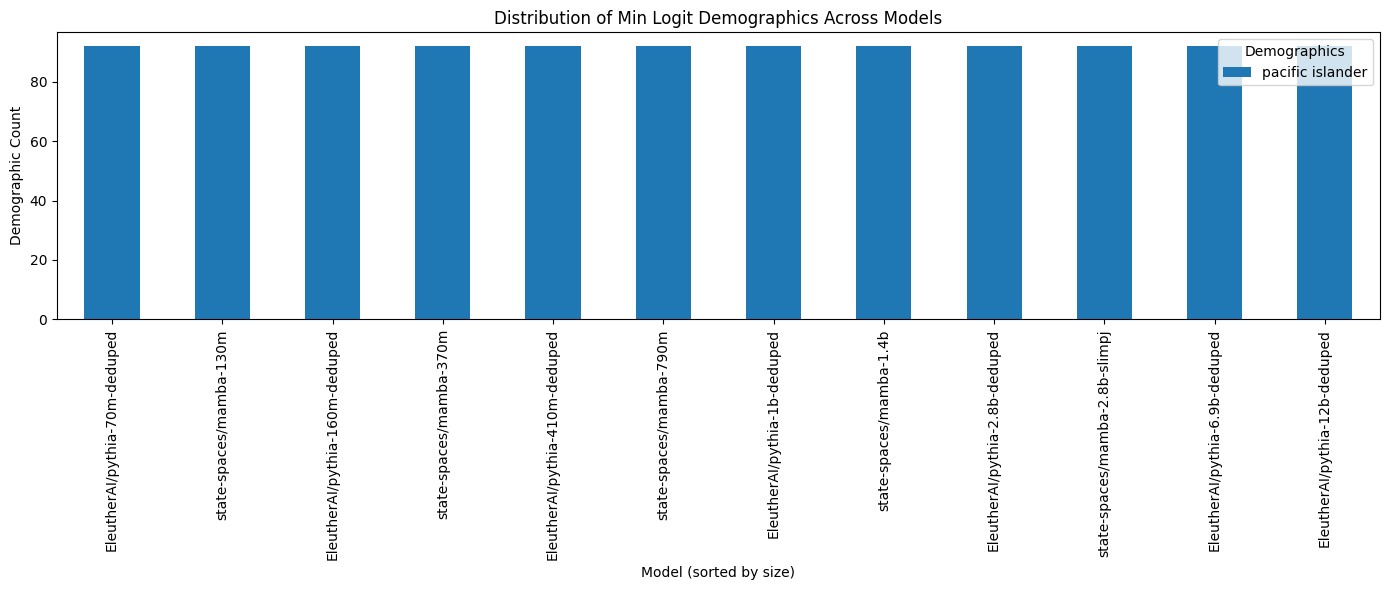

In [74]:
# Apply the function to the 'max_logit_demographics' column
df_sorted['logit_demographics_distribution'] = df_sorted['min_logit_demographics'].apply(count_demographics)

# Now, we need to restructure this data to be suitable for a stacked bar chart
# We'll create a DataFrame where each row represents a model, and each column represents a demographic,
# with cell values indicating the count of that demographic for the model

# Extract all unique demographics across all models for 'max_logit_demographics'
all_demographics = set(demographic for sublist in df_sorted['min_logit_demographics'] for demographic in sublist)

# Initialize a DataFrame to hold the restructured data
demographics_df = pd.DataFrame(columns=['Model'] + list(all_demographics))

# Populate the DataFrame
demographics_df['Model'] = df_sorted['model_name']
for demographic in all_demographics:
    demographics_df[demographic] = df_sorted['logit_demographics_distribution'].apply(lambda x: x.get(demographic, 0))

# Remove the 'Model' column for plotting
demographics_df_for_plotting = demographics_df.drop('Model', axis=1)

# Plotting
demographics_df_for_plotting.plot(kind='bar', stacked=True, figsize=(14, 6), legend=True)
plt.title('Distribution of Min Logit Demographics Across Models')
plt.xlabel('Model (sorted by size)')
plt.ylabel('Demographic Count')
plt.xticks(ticks=range(len(df_sorted['model_name'])), labels=df_sorted['model_name'], rotation=90)
plt.legend(title='Demographics')
plt.tight_layout()
plt.show()

In [22]:
# Initialize a dictionary to hold the ACC scores for each model
acc_scores_dict = {}

# Iterate through the model_demographics_dict
for model_name, demographics_info in model_demographics_dict.items():
    max_logit = demographics_info["max_logit_demographics"]
    min_logit = demographics_info["min_logit_demographics"]
    max_mentions = demographics_info["max_mentions_demographics"]
    min_mentions = demographics_info["min_mentions_demographics"]

    # Calculate the ACC scores
    max_acc = sum(
        1 for max_l, max_m in zip(max_logit, max_mentions) if max_l == max_m
    ) / len(max_logit)
    min_acc = sum(
        1 for min_l, min_m in zip(min_logit, min_mentions) if min_l == min_m
    ) / len(min_logit)

    # Store the scores in the dictionary
    acc_scores_dict[model_name] = {"Max ACC": max_acc, "Min ACC": min_acc}

acc_scores_dict

{'EleutherAI/pythia-70m-deduped': {'Max ACC': 0.043478260869565216,
  'Min ACC': 1.0},
 'EleutherAI/pythia-160m-deduped': {'Max ACC': 0.17391304347826086,
  'Min ACC': 1.0},
 'EleutherAI/pythia-410m-deduped': {'Max ACC': 0.03260869565217391,
  'Min ACC': 1.0},
 'EleutherAI/pythia-1b-deduped': {'Max ACC': 0.043478260869565216,
  'Min ACC': 1.0},
 'EleutherAI/pythia-2.8b-deduped': {'Max ACC': 0.07608695652173914,
  'Min ACC': 1.0},
 'EleutherAI/pythia-6.9b-deduped': {'Max ACC': 0.03260869565217391,
  'Min ACC': 1.0},
 'EleutherAI/pythia-12b-deduped': {'Max ACC': 0.03260869565217391,
  'Min ACC': 1.0},
 'state-spaces/mamba-130m': {'Max ACC': 0.34782608695652173, 'Min ACC': 1.0},
 'state-spaces/mamba-370m': {'Max ACC': 0.10869565217391304, 'Min ACC': 1.0},
 'state-spaces/mamba-790m': {'Max ACC': 0.8586956521739131, 'Min ACC': 1.0},
 'state-spaces/mamba-1.4b': {'Max ACC': 0.043478260869565216, 'Min ACC': 1.0},
 'state-spaces/mamba-2.8b-slimpj': {'Max ACC': 0.05434782608695652,
  'Min ACC': 

In [23]:
# Plotting with Plotly Express
fig = px.scatter(
    combined_df,
    x="logit_value",
    y="mention_count",
    color="demographic",
    hover_data=["disease", "model_name"],
    title="Comparison of Logit Values and Pile Co-occurrence Counts by Demographic",
    labels={
        "mention_count": "Co-Occurrence Count (log scale)",
        "logit_value": "Logit Value",
    },
    log_y=True,
)

# Customize for clarity
fig.update_traces(
    marker=dict(size=10, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(legend_title_text="Demographic", hovermode="closest")

fig.show()

In [24]:
# List of diseases to plot
diseases_to_plot = combined_df["disease"].unique()[:1]  # Adjust as needed

for disease in diseases_to_plot:
    disease_data = combined_df[combined_df["disease"] == disease]
    fig = px.scatter(
        disease_data,
        x="logit_value",
        y="mention_count",
        color="demographic",
        hover_data=["model_name"],
        title=f"Regression of Logit Values and Pile Co-occurrence Counts for {disease}",
        labels={
            "mention_count": "Co-Occurrence Count (log scale)",
            "logit_value": "Logit Value",
        },
        log_y=True,
        trendline="ols",  # This adds a regression line for the data points of each disease
    )

    # Customize for clarity
    fig.update_traces(
        marker=dict(size=10, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )
    fig.update_layout(legend_title_text="Demographic", hovermode="closest")

    fig.show()

/home/legionjgally/miniconda3/envs/in_biased_learning/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/home/legionjgally/miniconda3/envs/in_biased_learning/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/home/legionjgally/miniconda3/envs/in_biased_learning/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/home/legionjgally/miniconda3/envs/in_biased_learning/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/home/legionjgally/miniconda3/envs/in_biased_learning/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/home/legionjgally/miniconda3/envs/in_biased_learning/l

## Rank based eval

### Kendall Tau

Kendall Tau (\(\tau\)) is a correlation coefficient used to measure the ordinal association between two rankings. It evaluates the agreement between the ranks assigned to the same set of items in two different rankings.

- **Value Range**: -1 to 1
  - **1**: Perfect agreement
  - **-1**: Perfect disagreement
  - **0**: No association

### Rank Biased Overlap (RBO)

RBO assesses the similarity between two ranked lists, particularly useful when the lists are of different lengths and the top-ranked items are of most interest. It accounts for the order of items and emphasizes early ranks.

- **Value Range**: 0 to 1
  - **1**: Identical rankings
  - **0**: No overlap


In [25]:
combined_df

,disease,demographic,logit_value,model_name,model_size,mention_count,normalized_by_demo_mentions
0,hiv/aids,pacific islander,-169.595222,EleutherAI/pythia-70m-deduped,70,33654,0.447564
1,hiv/aids,pacific islander,-191.432622,EleutherAI/pythia-160m-deduped,160,33654,0.447564
2,hiv/aids,pacific islander,-208.036883,EleutherAI/pythia-410m-deduped,410,33654,0.447564
3,hiv/aids,pacific islander,-218.052256,EleutherAI/pythia-1b-deduped,1000,33654,0.447564
4,hiv/aids,pacific islander,-218.497273,EleutherAI/pythia-2.8b-deduped,2800,33654,0.447564
...,...,...,...,...,...,...,...
6619,arrhythmia,indigenous,-131.350694,state-spaces/mamba-130m,130,143534,2.733739
6620,arrhythmia,indigenous,-136.765625,state-spaces/mamba-370m,370,143534,2.733739
6621,arrhythmia,indigenous,-142.229167,state-spaces/mamba-790m,790,143534,2.733739
6622,arrhythmia,indigenous,-136.447917,state-spaces/mamba-1.4b,1400,143534,2.733739


In [39]:
# Calculate the quartiles for mention counts
def assign_quartile_grouped(row):
    disease = row["disease"]
    mention_count = row["mention_count"]
    quartiles = mention_quartiles[disease]

    if mention_count <= quartiles[0.25]:
        return "Q1"
    elif mention_count <= quartiles[0.5]:
        return "Q2"
    elif mention_count <= quartiles[0.75]:
        return "Q3"
    else:
        return "Q4"


# Calculate the quartiles for mention counts grouped by disease
mention_quartiles = combined_df.groupby("disease")["mention_count"].quantile(
    [0.25, 0.5, 0.75]
)

# Assign a quartile to each row within each disease group
combined_df["quartile"] = combined_df.apply(assign_quartile_grouped, axis=1)

# Display the DataFrame with the new 'quartile' column
combined_df.head()

,disease,demographic,logit_value,model_name,model_size,mention_count,normalized_by_demo_mentions,quartile
0,hiv/aids,pacific islander,-169.595222,EleutherAI/pythia-70m-deduped,70,33654,0.447564,Q1
1,hiv/aids,pacific islander,-191.432622,EleutherAI/pythia-160m-deduped,160,33654,0.447564,Q1
2,hiv/aids,pacific islander,-208.036883,EleutherAI/pythia-410m-deduped,410,33654,0.447564,Q1
3,hiv/aids,pacific islander,-218.052256,EleutherAI/pythia-1b-deduped,1000,33654,0.447564,Q1
4,hiv/aids,pacific islander,-218.497273,EleutherAI/pythia-2.8b-deduped,2800,33654,0.447564,Q1


In [27]:
# selectt combined_df where model_name start with EleutherAI/pythia
pythia = combined_df[combined_df["model_name"].str.contains("EleutherAI/pythia")]

# selectt combined_df where model_name start with state-spaces/mamba
mamba = combined_df[combined_df["model_name"].str.contains("state-spaces/mamba")]

In [41]:
rank_results_pythia = analyze_rank_results(pythia)
rank_results_mamba = analyze_rank_results(mamba)

In [42]:
rank_results_pythia.head()

,disease,model_size,kendall_tau,rbo_score,quartile
0,hiv/aids,70,0.333333,0.619444,Q3
1,hiv/aids,160,0.600000,0.480556,Q3
2,hiv/aids,410,0.733333,0.730556,Q3
3,hiv/aids,1000,0.600000,0.480556,Q3
4,hiv/aids,2800,0.600000,0.480556,Q3


#### Quartiles


In [48]:
# mean of kendall_tau and rbo_score for each quartile for each model size
quartile_pythia = (
    rank_results_pythia.groupby(["model_size", "quartile"])[
        ["kendall_tau", "rbo_score"]
    ]
    .mean()
    .reset_index()
)
quartile_mamba = (
    rank_results_mamba.groupby(["model_size", "quartile"])[["kendall_tau", "rbo_score"]]
    .mean()
    .reset_index()
)

quartile_pythia.head()

,model_size,quartile,kendall_tau,rbo_score
0,70,Q1,0.353333,0.705556
1,70,Q2,0.346667,0.700926
2,70,Q3,0.386667,0.674722
3,70,Q4,0.400000,0.674306
4,160,Q1,0.533333,0.661667


In [49]:
# plot distribution of kendall tau scores
fig_kendall_tau = px.line(
    quartile_pythia,
    x="model_size",
    y="kendall_tau",
    color="quartile",
    title="Kendall Tau Scores by Quartile and Model Size for pythia",
    labels={
        "model_size": "Model Size",
        "kendall_tau": "Kendall Tau Score",
        "quartile": "quartile",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

In [50]:
# plot distribution of kendall tau scores
fig_kendall_tau = px.line(
    quartile_mamba,
    x="model_size",
    y="kendall_tau",
    color="quartile",
    title="Kendall Tau Scores by Quartile and Model Size for mamba",
    labels={
        "model_size": "Model Size",
        "kendall_tau": "Kendall Tau Score",
        "quartile": "quartile",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

#### Avg model size


In [52]:
# Calculate mean of kendall_tau and rbo_score across model sizes
pythia_mean_scores = (
    rank_results_pythia.groupby("model_size")[["kendall_tau", "rbo_score"]]
    .mean()
    .reset_index()
)
mamba_mean_scores = (
    rank_results_mamba.groupby("model_size")[["kendall_tau", "rbo_score"]]
    .mean()
    .reset_index()
)

In [53]:
# Plotting Kendall Tau Scores vs. Model Size
fig_kendall_tau = px.line(
    pythia_mean_scores,
    x="model_size",
    y="kendall_tau",
    title="Average Kendall Tau Scores by Model Size",
    labels={
        "model_size": "Model Size",
        "kendall_tau": "Average Kendall Tau Score",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

In [54]:
# Plotting Kendall Tau Scores vs. Model Size
fig_kendall_tau = px.line(
    mamba_mean_scores,
    x="model_size",
    y="kendall_tau",
    title="Average Kendall Tau Scores by Model Size",
    labels={
        "model_size": "Model Size",
        "kendall_tau": "Average Kendall Tau Score",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

#### Disease spread


In [30]:
# plot distribution of kendall tau scores
fig_kendall_tau = px.line(
    rank_results_pythia,
    x="model_size",
    y="kendall_tau",
    color="disease",
    title="Kendall Tau Scores by Disease and Model Size for pythia",
    labels={
        "model_size": "Model Size",
        "kendall_tau": "Kendall Tau Score",
        "disease": "Disease",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

In [31]:
fig_rbo_score = px.line(
    rank_results_pythia,
    x="model_size",
    y="rbo_score",
    color="disease",
    title="RBO Scores by Disease and Model Size for pythia",
    labels={"model_size": "Model Size", "rbo_score": "RBO Score", "disease": "Disease"},
    markers=True,  # Add markers for each point
)

fig_rbo_score.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_rbo_score.show()

In [32]:
# plot distribution of kendall tau scores
fig_kendall_tau = px.line(
    rank_results_mamba,
    x="model_size",
    y="kendall_tau",
    color="disease",
    title="Kendall Tau Scores by Disease and Model Size for mamba",
    labels={
        "model_size": "Model Size",
        "kendall_tau": "Kendall Tau Score",
        "disease": "Disease",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

In [33]:
fig_rbo_score = px.line(
    rank_results_mamba,
    x="model_size",
    y="rbo_score",
    color="disease",
    title="RBO Scores by Disease and Model Size for mamba",
    labels={"model_size": "Model Size", "rbo_score": "RBO Score", "disease": "Disease"},
    markers=True,  # Add markers for each point
)

fig_rbo_score.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_rbo_score.show()

## Correlations


In [34]:
# Calculate Pearson correlation
correlation_matrix = combined_df[
    ["logit_value", "mention_count", "normalized_by_demo_mentions"]
].corr()

correlation_matrix

,logit_value,mention_count,normalized_by_demo_mentions
logit_value,1.000000,0.177446,0.264461
mention_count,0.177446,1.000000,0.299107
normalized_by_demo_mentions,0.264461,0.299107,1.000000


In [35]:
# Function to calculate correlation per demographic
def calculate_correlation_per_demographic(dataframe):
    demographic_groups = dataframe["demographic"].unique()
    correlation_results = {}

    for demographic in demographic_groups:
        subset = dataframe[dataframe["demographic"] == demographic]
        correlation_matrix = subset[
            ["logit_value", "mention_count", "normalized_by_demo_mentions"]
        ].corr()
        correlation_results[demographic] = correlation_matrix

    return correlation_results


# Calculate and print correlation per demographic
correlation_results = calculate_correlation_per_demographic(combined_df)
for demographic, correlation_matrix in correlation_results.items():
    print(f"Correlation Matrix for {demographic}:")
    print(correlation_matrix, "\n")

Correlation Matrix for pacific islander:
                             logit_value  mention_count  \
logit_value                     1.000000       0.165134   
mention_count                   0.165134       1.000000   
normalized_by_demo_mentions     0.160683       0.266781   

                             normalized_by_demo_mentions  
logit_value                                     0.160683  
mention_count                                   0.266781  
normalized_by_demo_mentions                     1.000000   

Correlation Matrix for hispanic:
                             logit_value  mention_count  \
logit_value                     1.000000       0.167633   
mention_count                   0.167633       1.000000   
normalized_by_demo_mentions     0.071755       0.187136   

                             normalized_by_demo_mentions  
logit_value                                     0.071755  
mention_count                                   0.187136  
normalized_by_demo_mentions          

## OLS


### Does co-occurrence have a good fit to logit?

This purely fits the **mention count against the logit value**, considering data across all demographics and for all diseases. <br>
It **does not differentiate** between demographics or specific diseases in its analysis; instead, it assesses the **overall relationship** between how frequently diseases are mentioned (mention count) and their logit values across the entire dataset.<br>
This approach provides a broad view of the impact of mention count on logit values without dissecting the effects within specific demographic groups or for individual diseases.


In [36]:
mention_column = "normalized_by_demo_mentions"

# Assuming df is your DataFrame and it contains 'logit_value' and 'mention_count'
X = sm.add_constant(combined_df[mention_column])  # Independent variable
y = combined_df["logit_value"]  # Dependent variable

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            logit_value   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     498.0
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          2.03e-106
Time:                        11:17:19   Log-Likelihood:                -30348.
No. Observations:                6624   AIC:                         6.070e+04
Df Residuals:                    6622   BIC:                         6.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

#### Controlling for model size, how does co-occurrence fit to logit?

Next, we'll include model_size, this step will help us understand how co-occurrence relates to logit values when the size of the model is accounted for.


In [37]:
X = sm.add_constant(combined_df[[mention_column, "model_size"]])
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            logit_value   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     416.8
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          3.11e-171
Time:                        11:17:20   Log-Likelihood:                -30195.
No. Observations:                6624   AIC:                         6.040e+04
Df Residuals:                    6621   BIC:                         6.042e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

#### Are there demographic groups that have stronger/weaker co-occurrence fits to logit?

Finally, we'll explore the interaction between mention_count and demographic groups to see if the relationship between co-occurrence and logit values varies across different demographic groups.


In [38]:
# One-hot encode demographic groups
df_encoded = pd.get_dummies(
    combined_df, columns=["demographic", "disease"], drop_first=False
)

# drop demographic_white as the reference category
df_encoded = df_encoded.drop(columns=["demographic_white"])

df_encoded = df_encoded.apply(lambda x: x.astype(int) if x.dtype == "bool" else x)

interaction_terms = []

# Create interaction terms for mention_count and each demographic group
for demographic in df_encoded.columns[
    df_encoded.columns.str.startswith("demographic_")
]:
    interaction_term = df_encoded[mention_column] * df_encoded[demographic]
    interaction_terms.append(interaction_term.rename(f"mention_{demographic}"))

# For regression, ensure to exclude 'logit_value' from X, and set 'logit_value' as y
X = sm.add_constant(
    df_encoded.drop(["logit_value", mention_column, "model_name"], axis=1)
)
y = df_encoded["logit_value"]

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

## HLM


In [ ]:
hml_stats_df = combined_df.copy()

md = smf.mixedlm(
    "logit_value ~ normalized_by_demo_mentions + C(demographic)",
    hml_stats_df,
    groups=hml_stats_df["model_size"],
)
mdf = md.fit()

print(mdf.summary())

                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          logit_value
No. Observations:          6624             Method:                      REML       
No. Groups:                11               Scale:                       353.9889   
Min. group size:           552              Log-Likelihood:              -28860.5313
Max. group size:           1104             Converged:                   Yes        
Mean group size:           602.2                                                    
------------------------------------------------------------------------------------
                                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------
Intercept                          -146.610    3.217 -45.568 0.000 -152.916 -140.304
C(demographic)[T.black]               8.447    1.777   4.753 0.000    4.964   11.930
C(de